In [1]:
import os
import pandas as pd
preprocessing_folder_path = '/home/local/PSYCH-ADS/xuqian_chen/Github/twitter_entropy/code/preprocessing/'
preprocessed_folder_path = '/home/local/PSYCH-ADS/xuqian_chen/Github/twitter_entropy/data/preprocessed/'
usdf = pd.read_csv(os.path.join(preprocessed_folder_path, 'us.csv'))
jpdf = pd.read_csv(os.path.join(preprocessed_folder_path, 'jp.csv'))


/tmp/ipykernel_3119760/537395398.py:5: DtypeWarning: Columns (19,20,21,58) have mixed types. Specify dtype option on import or set low_memory=False.
  usdf = pd.read_csv(os.path.join(preprocessed_folder_path, 'us.csv'))
/tmp/ipykernel_3119760/537395398.py:9: DtypeWarning: Columns (19,20,21,23,31,33,34,35,41) have mixed types. Specify dtype option on import or set low_memory=False.
  jpdf = pd.read_csv(os.path.join(preprocessed_folder_path, 'jp.csv'))


In [2]:
# get a random 10000 sample from usdf and jpdf

usdf = usdf.sample(n=10000, random_state=1)
jpdf = jpdf.sample(n=10000, random_state=1)

# entropy calculation

## load dict

In [3]:
def load_en_nrc_emotion_lexicon(txt_path):
    with open(txt_path, 'r') as f:
        lines = f.readlines()
        
    data = [line.strip().split('\t') for line in lines]
    df = pd.DataFrame(data, columns=["word", "emotion", "value"])
    df["value"] = df["value"].astype(int)
    
    df = df[df["value"] == 1]
    emotion_dict = {emotion: set(df[df["emotion"] == emotion]["word"]) for emotion in df["emotion"].unique()}
    
    return emotion_dict

# path_to_english_nrc = os.path.join(preprocessing_folder_path, 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
path_to_english_nrc = '/home/local/PSYCH-ADS/xuqian_chen/Github/twitter_entropy/data/preprocessing/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
english_nrc_emotion_dict = load_en_nrc_emotion_lexicon(path_to_english_nrc)


def load_jp_nrc_emotion_lexicon(file_path):
    emotion_dict = {"anger": set(), "anticipation": set(), "disgust": set(), "fear": set(), "joy": set(),
                    "negative": set(), "positive": set(), "sadness": set(), "surprise": set(), "trust": set()}

    with open(file_path, encoding="utf-8") as f:
        next(f)  # Skip the header line
        for line in f:
            split_line = line.strip().split("\t")
            japanese_word = split_line[-1]
            emotions = [emotion for emotion, value in zip(emotion_dict.keys(), split_line[1:-1]) if int(value) == 1]

            for emotion in emotions:
                emotion_dict[emotion].add(japanese_word.lower())

    return emotion_dict

# path_to_japanese_nrc = os.path.join(preprocessing_folder_path, 'Japanese-NRC-EmoLex.txt')
path_to_japanese_nrc = '/home/local/PSYCH-ADS/xuqian_chen/Github/twitter_entropy/data/preprocessing/Japanese-NRC-EmoLex.txt'
japanese_nrc_emotion_dict = load_jp_nrc_emotion_lexicon(path_to_japanese_nrc)


# NOT IN USE: roberta senetiment analysis

In [3]:
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

def get_emotion_loadings(tweet_text):
    model_name = "cardiffnlp/twitter-roberta-base-emotion"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    emotion_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    result = emotion_classifier(tweet_text)

    # Extract emotion probabilities
    emotion_probabilities = [entry["score"] for entry in result]
    return emotion_probabilities

# Example usage
tweet_text = "I love this new phone! It's amazing."
emotion_loadings = get_emotion_loadings(tweet_text)
print("Emotion loadings:", emotion_loadings)

def emotion_entropy(post_emotions, threshold=0.5):
    binary_emotions = [1 if emotion >= threshold else 0 for emotion in post_emotions]
    probabilities = [emotion_count / len(post_emotions) for emotion_count in binary_emotions]
    
    entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probabilities])
    return entropy

# Example usage
post_emotions = [0.7, 0.2, 0.8, 0.4, 0.6, 0.1]
entropy = emotion_entropy(post_emotions)
print("Emotion entropy:", entropy)

tweet_text = "I love this new phone! It's amazing."
emotion_loadings = get_emotion_loadings(tweet_text)
entropy = emotion_entropy(emotion_loadings)
print("Emotion loadings:", emotion_loadings)
print("Emotion entropy:", entropy)


2023-06-20 22:26:10.963327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-20 22:26:10.963347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Emotion loadings: [0.9440009593963623]
Emotion entropy: 1.292481250360578
Emotion loadings: [0.9440009593963623]
Emotion entropy: -0.0


# DDR

In [4]:
basic_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

ja_basic_emotion_concepts = {
    emotion: list(words) for emotion, words in japanese_nrc_emotion_dict.items() if emotion in basic_emotions
}
en_basic_emotion_concepts = {
    emotion: list(words) for emotion, words in english_nrc_emotion_dict.items() if emotion in basic_emotions
}

import fasttext
import fasttext.util
# check if the fastText embeddings are downloaded
import os

if not os.path.isfile('cc.ja.300.bin'):
    fasttext.util.download_model('ja', if_exists='ignore') 
if not os.path.isfile('cc.en.300.bin'):
    fasttext.util.download_model('en', if_exists='ignore')

ja_embeddings = fasttext.load_model('cc.ja.300.bin')
en_embeddings = fasttext.load_model('cc.en.300.bin')


## function: english emotions

In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import gensim.downloader as api

# load pre-trained fastText embeddings
def load_fasttext_embeddings(model_name):
    model = api.load(model_name)
    # Get the mean vector for the list of words
    # mean_vector = np.mean([model1[word] for word in wordlist if word in word_vectors], axis=0)

    return model

# Load pre-trained GloVe embeddings
def load_glove_embeddings(embeddings_file):
    embeddings = {}
    with open(embeddings_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

# Vectorize the dictionary of moral and emotional concepts
def vectorize_concepts(concepts, embeddings):
    concept_vectors = {}
    for concept, words in concepts.items():
        vectors = [embeddings[word] for word in words if word in embeddings]
        if vectors:  # Checking if the list is not empty
            concept_vectors[concept] = np.mean(vectors, axis=0)
        
    return concept_vectors


# Vectorize the input text
def vectorize_text(text, embeddings):
    tokens = word_tokenize(text)
    vectors = [embeddings[token] for token in tokens if token in embeddings and token is not None]
    if vectors:  # Checking if the list is not empty
        return np.mean(vectors, axis=0)

# Calculate cosine similarity between input text and moral and emotional concepts
def calculate_similarities(text_vector, concept_vectors):
    similarities = {}
    if text_vector is not None:
        for concept, vector in concept_vectors.items():
            similarities[concept] = cosine_similarity(text_vector.reshape(1, -1), vector.reshape(1, -1))[0][0]
    else:
        for concept, vector in concept_vectors.items():
            similarities[concept] = np.nan
    return similarities

# Example usage:
# glove_embeddings_file = 'glove.6B.300d.txt'
# glove_embeddings = load_glove_embeddings(glove_embeddings_file)
# en_embeddings = load_fasttext_embeddings("fasttext-wiki-news-subwords-300")

# Define your moral and emotional concepts dictionary here
en_concept_vectors = vectorize_concepts(en_basic_emotion_concepts, en_embeddings)

text = "This is an example text to analyze moral and emotional content."
text_vector = vectorize_text(text, en_embeddings)

similarities = calculate_similarities(text_vector, en_concept_vectors)
print(similarities)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'fear': 0.41364262, 'sadness': 0.42352968, 'anger': 0.42670828, 'surprise': 0.4825517, 'disgust': 0.39483726, 'joy': 0.4491447}


In [10]:
len(en_basic_emotion_concepts)
len(en_concept_vectors)

6

# jp emotions

## NOT IN USE: Tokenize the input text using Janome

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from janome.tokenizer import Tokenizer

# Load pre-trained FastText embeddings
def load_fasttext_embeddings(embeddings_file):
    embeddings = {}
    with open(embeddings_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

# Vectorize the dictionary of moral and emotional concepts
def vectorize_concepts(concepts, embeddings):
    concept_vectors = {}
    for concept, words in concepts.items():
        vectors = [embeddings[word] for word in words if word in embeddings]
        concept_vectors[concept] = np.mean(vectors, axis=0)
    return concept_vectors

# Tokenize the input text using Janome
def tokenize_japanese_text(text):
    tokenizer = Tokenizer()
    tokens = tokenizer.tokenize(text, wakati=True)
    return tokens

# Vectorize the input text
def vectorize_text(tokens, embeddings):
    vectors = [embeddings[token] for token in tokens if token in embeddings]
    return np.mean(vectors, axis=0)

# Calculate cosine similarity between input text and moral and emotional concepts
def calculate_similarities(text_vector, concept_vectors):
    similarities = {}
    for concept, vector in concept_vectors.items():
        similarities[concept] = cosine_similarity(text_vector.reshape(1, -1), vector.reshape(1, -1))[0][0]
    return similarities

# ENTROPY
def emotion_entropy(post_emotions, threshold=0.5):
    binary_emotions = [1 if emotion >= threshold else 0 for emotion in post_emotions]
    probabilities = [emotion_count / len(post_emotions) for emotion_count in binary_emotions]
    
    entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probabilities])
    return entropy
# Define your moral and emotional concepts dictionary here
concepts = en_basic_emotion_concepts

concept_vectors = vectorize_concepts(concepts, en_embeddings)

text = "His success is wonderful, but at the same time, I feel a bit jealous."
text_vector = vectorize_text(text, en_embeddings)

similarities = calculate_similarities(text_vector, concept_vectors)

entropy = emotion_entropy(list(similarities.values()))
print(similarities)
print(entropy)

{'fear': 0.28294072, 'sadness': 0.28086483, 'anger': 0.28085762, 'surprise': 0.30233887, 'disgust': 0.28768104, 'joy': 0.27653188}
0


## USE THIS

In [6]:
import MeCab
mecab = MeCab.Tagger("-Owakati")
def tokenize_japanese_text_mecab(text):
    mecab = MeCab.Tagger("-Owakati")
    return mecab.parse(text).strip().split()

def vectorize_jp_concepts(concepts, ja_embeddings):
    concept_vectors = {}
    for concept, words in concepts.items():
        vectors = [ja_embeddings.get_word_vector(word) for word in words if word is not None]
        if vectors:  # Checking if the list is not empty
            concept_vectors[concept] = np.mean(vectors, axis=0)
    return concept_vectors

# Vectorize the input text
def vectorize_jp_text(text, ja_embeddings):
    tokens = mecab.parse(text).strip().split()
    vectors =[ja_embeddings.get_word_vector(token) for token in tokens if token is not None]
    if vectors:  # Checking if the list is not empty
        return np.mean(vectors, axis=0)

def emotion_entropy(post_emotions, threshold=0.5):
    binary_emotions = [1 if emotion >= threshold else 0 for emotion in post_emotions]
    probabilities = [emotion_count / len(post_emotions) for emotion_count in binary_emotions]
    
    entropy = -np.sum([p * np.log2(p) if p > 0 else 0 for p in probabilities])
    return entropy

def calculate_mixed_emotion_entropy(sentence, embeddings,concept_vectors, language):
    if language == 'ja':
        
        text_vector = vectorize_jp_text(sentence, embeddings)
        
    else:
        text_vector = vectorize_text(sentence, embeddings)
    similarities = calculate_similarities(text_vector, concept_vectors)
    entropy = emotion_entropy(list(similarities.values()))
    return similarities, entropy

# Example usage:
# fasttext_embeddings_file = 'cc.ja.300.vec'
# fasttext_embeddings = load_fasttext_embeddings(fasttext_embeddings_file)

# Define your moral and emotional concepts dictionary here
ja_concept_vectors = vectorize_jp_concepts(ja_basic_emotion_concepts, ja_embeddings)

# concept_vectors = vectorize_concepts(concepts, ja_embeddings)

text = "これは道徳的および感情的なコンテンツを分析するための例文です"

text_vector = vectorize_jp_text(text, ja_embeddings)

similarities = calculate_similarities(text_vector, ja_concept_vectors)

entropy = emotion_entropy(list(similarities.values()))
print(similarities)
print(entropy)

{'anger': 0.6377529, 'disgust': 0.611441, 'fear': 0.62469923, 'joy': 0.6755975, 'sadness': 0.6264248, 'surprise': 0.67802525}
2.584962500721156


In [16]:
en_mixed_emotion_sentences = [
    "I'm so happy to see you, but I'm sad that you have to leave soon.",
    
    "I'm anxious about the exam, but I'm also excited about the challenge.",
    
    "I'm surprised and disappointed by the news.",
]

ja_mixed_emotion_sentences = [
    "彼の成功は素晴らしいけれども、同時に少し嫉妬心がある",
    "仕事が終わったので安心だが、週末のパーティには緊張している",
    "彼女の発表には驚いたが、ちょっと怒りも感じた",
]


for sentence in en_mixed_emotion_sentences:
    similarities, entropy = calculate_mixed_emotion_entropy(sentence, en_embeddings,en_concept_vectors,'en')
    print(sentence, similarities, entropy)

# for sentence in ja_mixed_emotion_sentences:
#     similarities, entropy = calculate_mixed_emotion_entropy(sentence, ja_embeddings, language='ja')
#     print(sentence, similarities, entropy)


I'm so happy to see you, but I'm sad that you have to leave soon. {'fear': 0.37510112, 'sadness': 0.4106004, 'anger': 0.3957127, 'surprise': 0.45528018, 'disgust': 0.38073587, 'joy': 0.43462116} 0
I'm anxious about the exam, but I'm also excited about the challenge. {'fear': 0.35617098, 'sadness': 0.38363206, 'anger': 0.37038344, 'surprise': 0.41533512, 'disgust': 0.35978395, 'joy': 0.39620787} 0
I'm surprised and disappointed by the news. {'fear': 0.37021956, 'sadness': 0.39169207, 'anger': 0.38696086, 'surprise': 0.4206731, 'disgust': 0.36965284, 'joy': 0.38753808} 0


In [85]:
import cProfile

def test():
    for sentence in en_mixed_emotion_sentences:
        similarities, entropy = calculate_mixed_emotion_entropy(sentence, en_embeddings,en_concept_vectors,'en')


    # for sentence in ja_mixed_emotion_sentences:
        # similarities, entropy = calculate_mixed_emotion_entropy(sentence, ja_embeddings, ja_concept_vectors, language='ja')


cProfile.run('test()')


         6396 function calls in 0.008 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.000    0.000 1999364120.py:42(emotion_entropy)
        3    0.000    0.000    0.000    0.000 1999364120.py:43(<listcomp>)
        3    0.000    0.000    0.000    0.000 1999364120.py:44(<listcomp>)
        3    0.000    0.000    0.000    0.000 1999364120.py:46(<listcomp>)
        1    0.000    0.000    0.008    0.008 2842563575.py:3(test)
        3    0.000    0.000    0.003    0.001 2887436742.py:34(vectorize_text)
        3    0.000    0.000    0.001    0.000 2887436742.py:36(<listcomp>)
        3    0.000    0.000    0.005    0.002 2887436742.py:40(calculate_similarities)
        3    0.000    0.000    0.008    0.003 61706619.py:15(calculate_mixed_emotion_entropy)
       36    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(einsum)
       36    0.000    0.000    0.000    0.000 <__array

In [7]:
mixed_emotion_sentences = {
    "sentence1": "I'm thrilled to have received the promotion, but I'm also nervous about the new responsibilities that come with it.",
    "sentence2": "I was relieved that the medical test came back negative, but I'm still worried about my persistent symptoms.",
    "sentence3": "I'm excited to start this new chapter in my life, but I'm sad about leaving my friends and family behind.",
    "sentence4": "It's heartbreaking to say goodbye to my colleagues, but I am eager to explore the new job opportunity.",
    "sentence5": "I'm proud of my children for becoming independent, but I'm also feeling a little lonely now that they've moved out.",
    "sentence6": "I feel joyous for my friend's wedding, but at the same time, I'm feeling a bit envious.",
}
en_mixed_emotion_sentences = list(mixed_emotion_sentences.values())

ja_mixed_emotion_sentences= [
    "昇進してとてもうれしいですが、新しい責任にも少し緊張しています。",
    "医療検査が陰性でほっとしていますが、持続的な症状についてはまだ心配しています。",
    "新しい生活の章を開始するのが楽しみですが、友人や家族と離れることは悲しいです。",
    "同僚に別れを告げるのは心が痛むけれど、新たな仕事の機会を探求することには前向きです。",
    "子どもたちが自立してくれて誇らしいですが、彼らが引っ越してからは少し寂しい気もします。",
    "友人の結婚に喜んでいる一方で、少し羨ましい気もします。",
]


for sentence in en_mixed_emotion_sentences:
    similarities, entropy = calculate_mixed_emotion_entropy(sentence, en_embeddings,en_concept_vectors,'en')
    print(sentence, similarities, entropy)

for sentence in ja_mixed_emotion_sentences:
    similarities, entropy = calculate_mixed_emotion_entropy(sentence, ja_embeddings,ja_concept_vectors, language='ja')
    print(sentence, similarities, entropy)



I'm thrilled to have received the promotion, but I'm also nervous about the new responsibilities that come with it. {'fear': 0.40171182, 'sadness': 0.42628872, 'anger': 0.41740063, 'surprise': 0.47821122, 'disgust': 0.3979503, 'joy': 0.4570658} 0
I was relieved that the medical test came back negative, but I'm still worried about my persistent symptoms. {'fear': 0.4363569, 'sadness': 0.46855167, 'anger': 0.44494748, 'surprise': 0.49110755, 'disgust': 0.43099725, 'joy': 0.4579231} 0
I'm excited to start this new chapter in my life, but I'm sad about leaving my friends and family behind. {'fear': 0.41011915, 'sadness': 0.44670123, 'anger': 0.42168626, 'surprise': 0.48029304, 'disgust': 0.40653476, 'joy': 0.47900426} 0
It's heartbreaking to say goodbye to my colleagues, but I am eager to explore the new job opportunity. {'fear': 0.399352, 'sadness': 0.42127678, 'anger': 0.41590914, 'surprise': 0.48764575, 'disgust': 0.3840257, 'joy': 0.47415847} 0
I'm proud of my children for becoming ind

# caculate tweets entropy

In [8]:
from tqdm import tqdm

entropies = []
angers = []
fears = []
joys = []
sadnesses = []
disgusts = []
surprises = []

for t in tqdm(usdf['text']):
    # similarities = calculate_similarities(text_vector, concept_vectors)
    try:
        similarities, entroppy = calculate_mixed_emotion_entropy(t, en_embeddings,en_concept_vectors,'en')
    except Exception as e:
        print(f"An error occurred: {e}")
        print(t)
        
        # Input
        similarities = {'anger':np.nan,'fear':np.nan,'joy':np.nan,'sadness':np.nan,'disgust':np.nan,'surprise':np.nan}
        entropy = np.nan
    entropies.append(entropy)
    angers.append(similarities['anger'])
    fears.append(similarities['fear'])
    joys.append(similarities['joy'])
    sadnesses.append(similarities['sadness'])
    disgusts.append(similarities['disgust'])
    surprises.append(similarities['surprise'])

# usdf['entropy'] = entropies
usdf['anger'] = angers
usdf['fear'] = fears
usdf['joy'] = joys
usdf['sadness'] = sadnesses
usdf['disgust'] = disgusts
usdf['surprise'] = surprises
usdf['entropy'] = entropies

100%|██████████| 10000/10000 [11:53<00:00, 14.02it/s]


In [20]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
def process_text_en(t):
    try:
        similarities, entropy = calculate_mixed_emotion_entropy(t, en_embeddings, en_concept_vectors, 'en')
    except Exception as e:
        print(f"An error occurred: {e}")
        # Input
        similarities = {'anger':np.nan, 'fear':np.nan, 'joy':np.nan, 'sadness':np.nan, 'disgust':np.nan, 'surprise':np.nan}
        entropy = np.nan

    return (similarities, entropy)

with Pool(cpu_count()) as p:
    results = list(tqdm(p.imap(process_text_en, usdf['text']), total=len(usdf)))

# save results
# import pickle
# with open(os.path.join(preprocessing_folder_path, 'usdf_mixed_emotion_results.pkl'), 'wb') as f:
#     pickle.dump(results, f)

# Separate the results into their respective lists
similarities_list, entropies = zip(*results)
angers, fears, joys, sadnesses, disgusts, surprises = zip(*[s.values() for s in similarities_list])

usdf['anger'] = angers
usdf['fear'] = fears
usdf['joy'] = joys
usdf['sadness'] = sadnesses
usdf['disgust'] = disgusts
usdf['surprise'] = surprises
usdf['entropy'] = entropies


100%|██████████| 10000/10000 [05:22<00:00, 31.01it/s]


In [10]:
from multiprocessing import Pool, cpu_count

def process_text_jp(t):
    try:
        similarities, entropy = calculate_mixed_emotion_entropy(t, ja_embeddings, ja_concept_vectors, 'ja')
    except Exception as e:
        print(f"An error occurred: {e}")
        # Input
        similarities = {'anger':np.nan, 'fear':np.nan, 'joy':np.nan, 'sadness':np.nan, 'disgust':np.nan, 'surprise':np.nan}
        entropy = np.nan

    return (similarities, entropy)

with Pool(cpu_count()) as p:
    results = list(tqdm(p.imap(process_text_jp, jpdf['text']), total=len(jpdf)))

# Separate the results into their respective lists
similarities_list, entropies = zip(*results)
angers, fears, joys, sadnesses, disgusts, surprises = zip(*[s.values() for s in similarities_list])

jpdf['anger'] = angers
jpdf['fear'] = fears
jpdf['joy'] = joys
jpdf['sadness'] = sadnesses
jpdf['disgust'] = disgusts
jpdf['surprise'] = surprises
jpdf['entropy'] = entropies


100%|██████████| 10000/10000 [00:00<00:00, 14891.12it/s]


In [13]:
# save the data
usdf.to_csv(os.path.join(preprocessed_folder_path,"us_entropy_test.csv"), index=False)
jpdf.to_csv(os.path.join(preprocessed_folder_path,"jp_entropy_test.csv") , index=False)
del ja_embeddings, ja_concept_vectors, en_embeddings, en_concept_vectors

# Descriptive

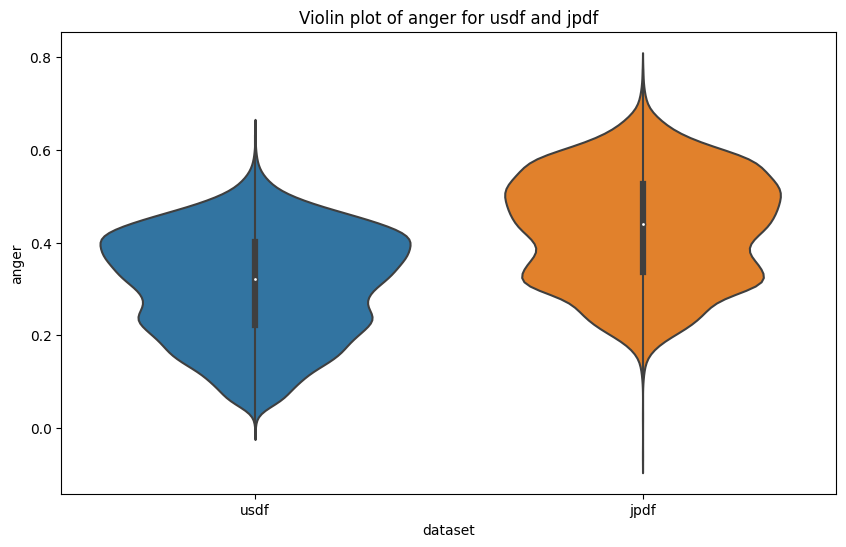

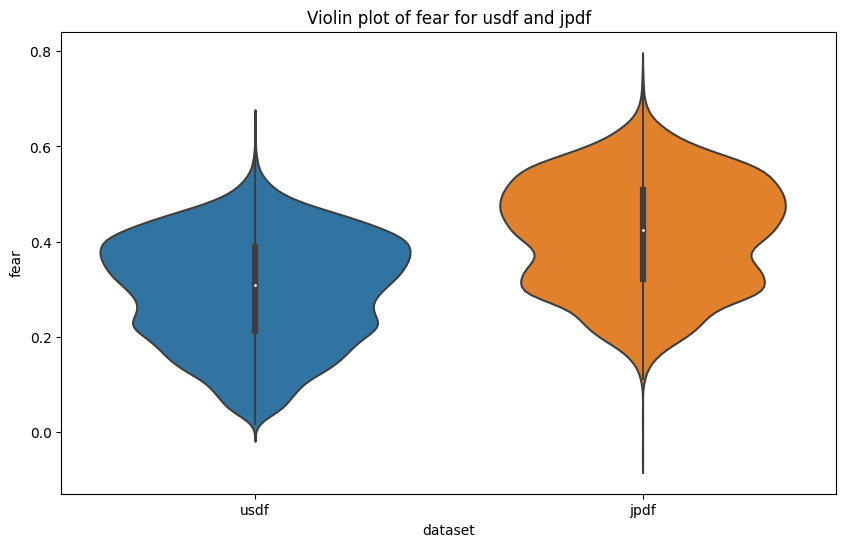

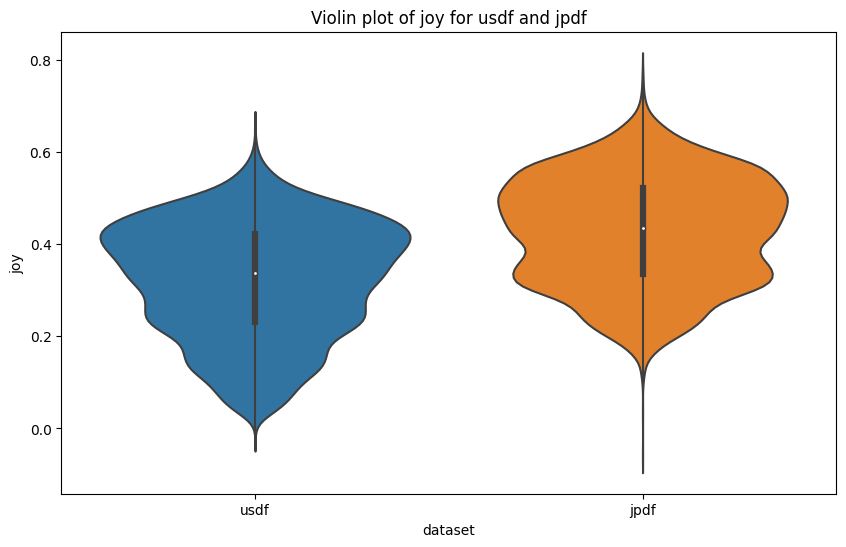

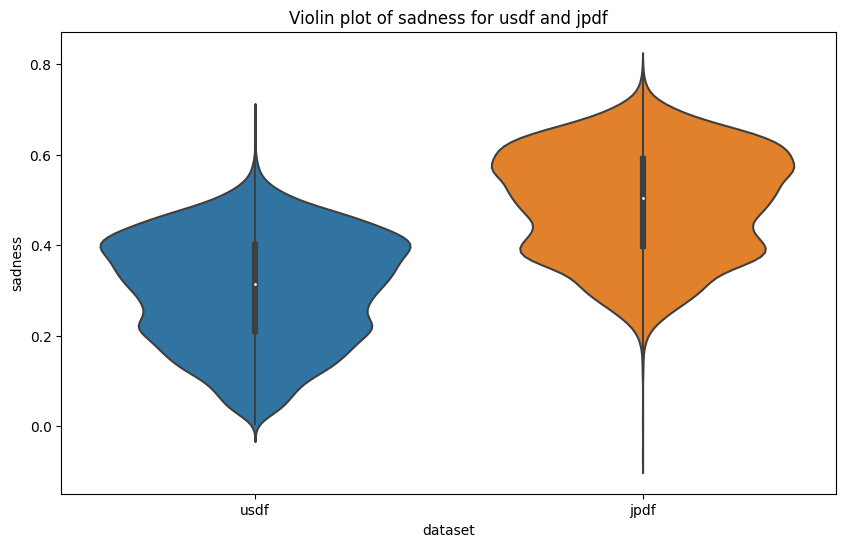

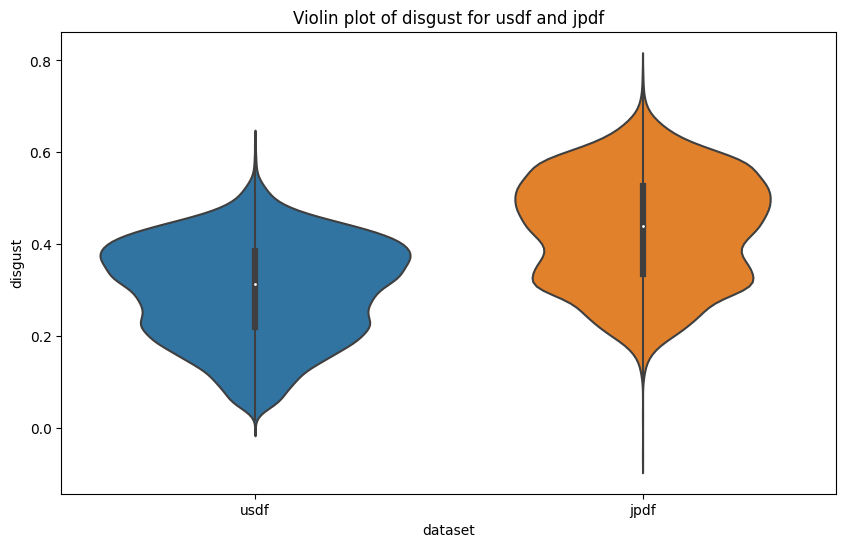

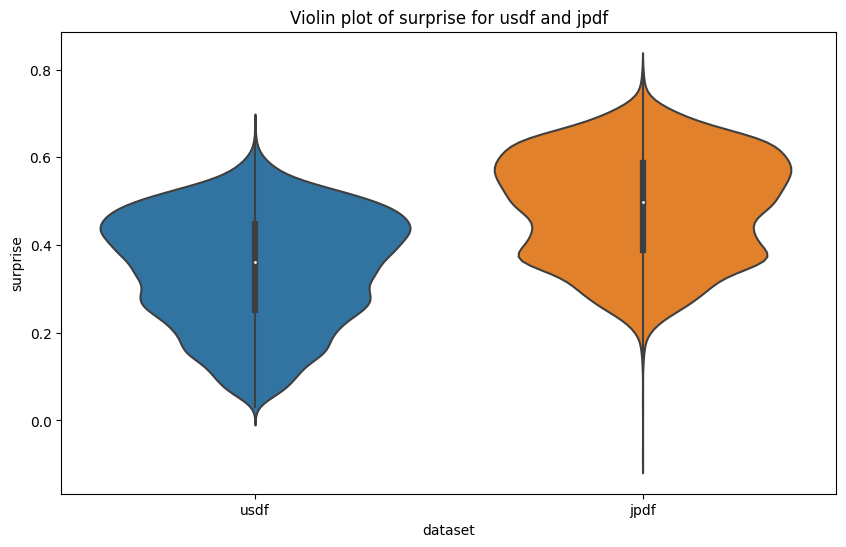

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each emotion and create a violin plot
for emotion in basic_emotions:
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Combine the two dataframes and create a new 'dataset' column which identifies the dataframe each row comes from
    combined_df = pd.concat([usdf[[emotion]].assign(dataset='usdf'), jpdf[[emotion]].assign(dataset='jpdf')])

    # Create the violin plot
    sns.violinplot(x="dataset", y=emotion, data=combined_df)

    # Add a title
    plt.title(f'Violin plot of {emotion} for usdf and jpdf')

    # Show the plot
    plt.show()


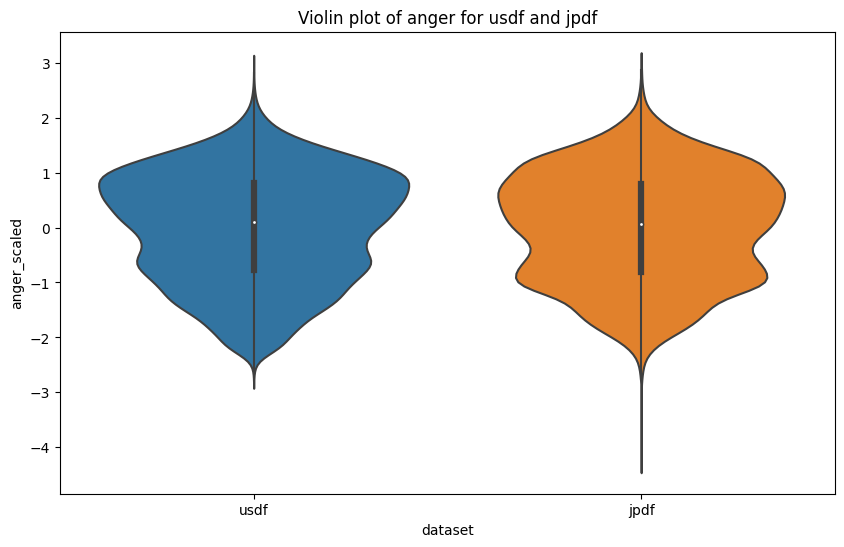

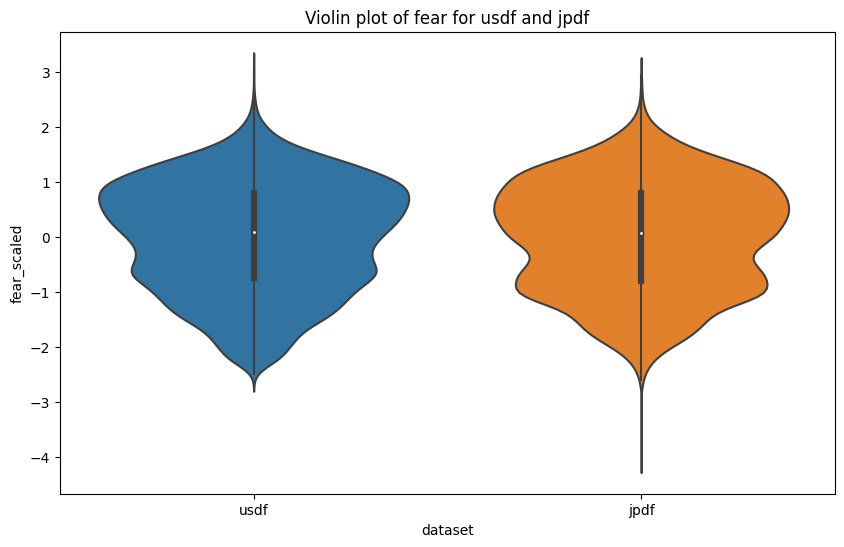

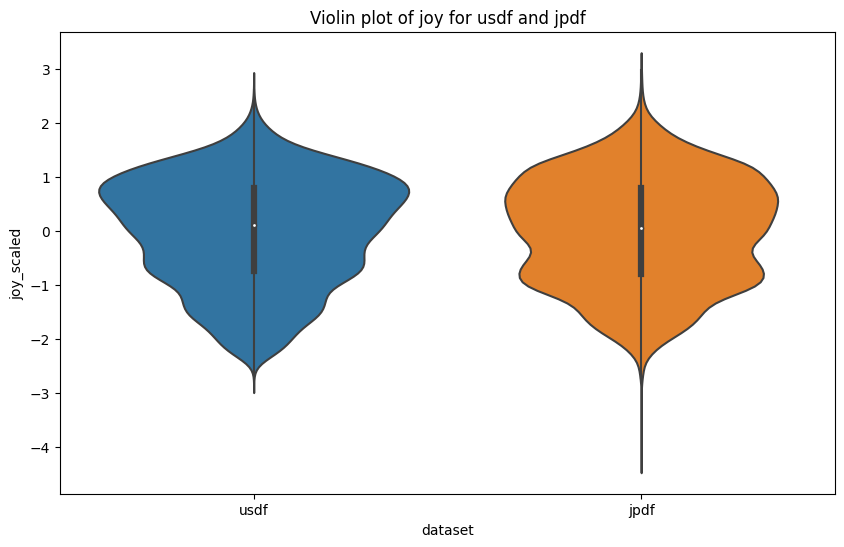

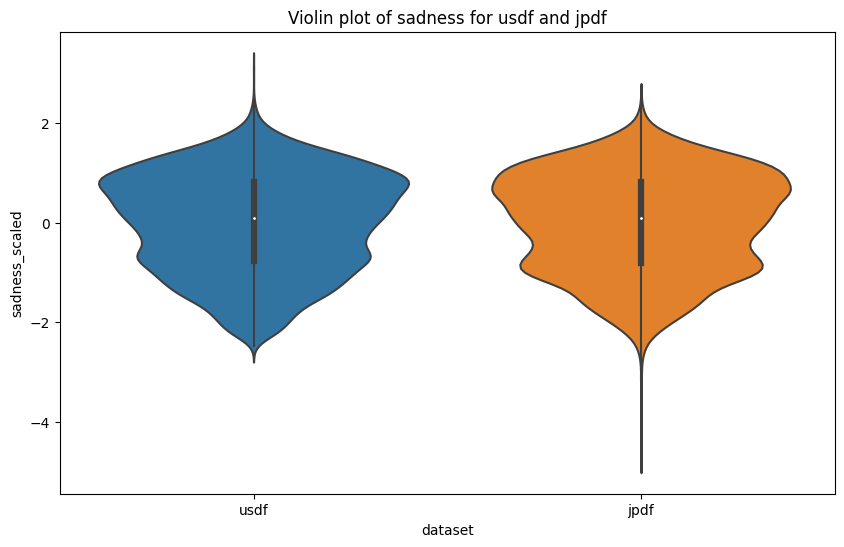

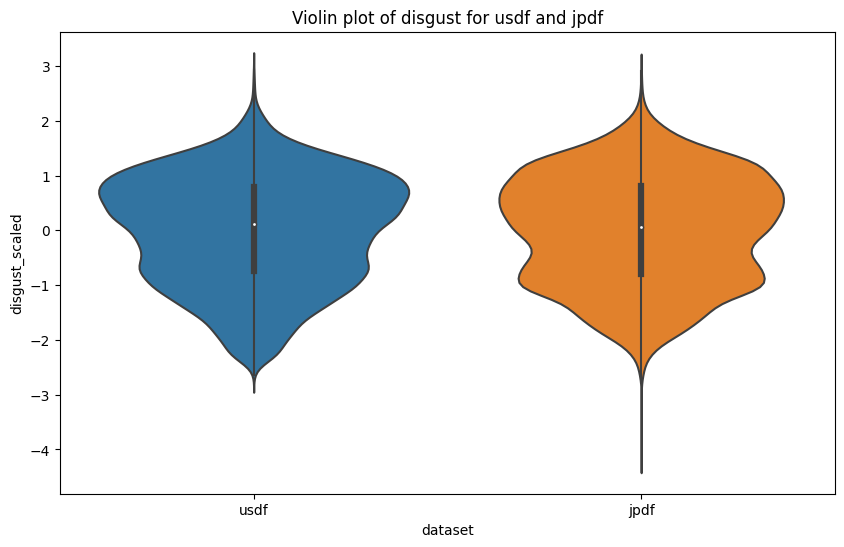

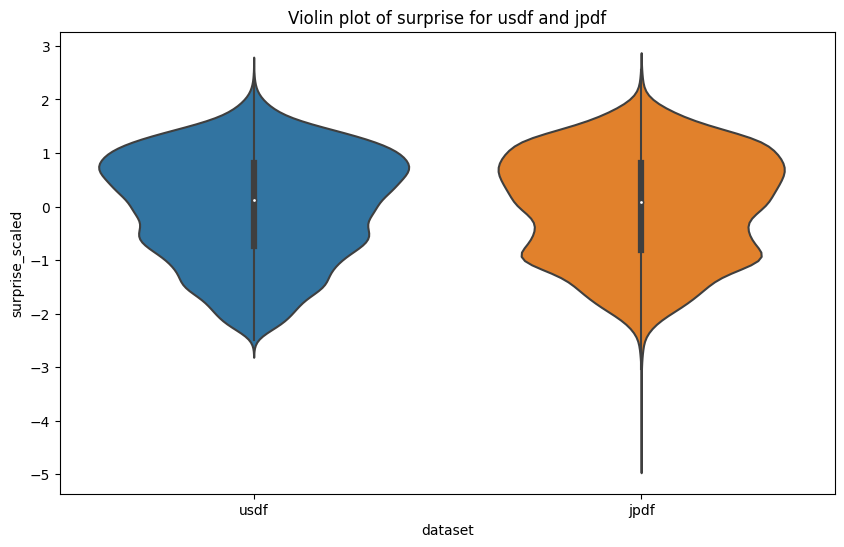

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Assume we have two dataframes: usdf and jpdf for two cultures
# Basic emotions list: basic_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

# Scale the emotions in usdf
for emotion in basic_emotions:
    usdf[emotion + '_scaled'] = scaler.fit_transform(usdf[emotion].values.reshape(-1, 1))

# Scale the emotions in jpdf
for emotion in basic_emotions:
    jpdf[emotion + '_scaled'] = scaler.fit_transform(jpdf[emotion].values.reshape(-1, 1))


# Loop through each emotion and create a violin plot
for emotion in basic_emotions:
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Combine the two dataframes and create a new 'dataset' column which identifies the dataframe each row comes from
    combined_df = pd.concat([usdf[[emotion + '_scaled']].assign(dataset='usdf'), jpdf[[emotion + '_scaled']].assign(dataset='jpdf')])

    # Create the violin plot
    sns.violinplot(x="dataset", y=emotion + '_scaled', data=combined_df)

    # Add a title
    plt.title(f'Violin plot of {emotion} for usdf and jpdf')

    # Show the plot
    plt.show()


In [45]:
# mean of all emotions
print( "mean of each emotion for US", usdf[basic_emotions].mean())
print("mean of each emotions for JP",jpdf[basic_emotions].mean())

print("mean of all emotions for US: ", usdf[basic_emotions].mean(axis=1).mean())
print("mean of all emotions for JP: ", jpdf[basic_emotions].mean(axis=1).mean())

# median of all emotions combined
print("median of all emotions for US: ", usdf[basic_emotions].median(axis=1).median())
print("median of all emotions for JP: ", jpdf[basic_emotions].median(axis=1).median())


mean of each emotion for US anger       0.308251
fear        0.298253
joy         0.322134
sadness     0.302450
disgust     0.299698
surprise    0.345809
dtype: float64
mean of each emotions for JP anger       0.432271
fear        0.415749
joy         0.427596
sadness     0.493394
disgust     0.431474
surprise    0.487919
dtype: float32
mean of all emotions for US:  0.31276583913362727
mean of all emotions for JP:  0.4480671
median of all emotions for US:  0.31920987367630005
median of all emotions for JP:  0.4406670928001404


In [43]:
entropies = []
basic_emotions_scaled = [e + '_scaled' for e in basic_emotions]
for t in range(len(usdf)):
    post_emotions = usdf.iloc[t][basic_emotions]
    try:
        entropy = emotion_entropy(post_emotions, threshold=0.32)
    except Exception as e:
        print(f"An error occurred: {e}")
        # Input
        entropy = np.nan
    entropies.append(entropy)
usdf['entropy_scaled'] = entropies

entropies = []
for t in range(len(jpdf)):
    post_emotions = jpdf.iloc[t][basic_emotions]
    try:
        entropy = emotion_entropy(post_emotions, threshold=0.44)
    except Exception as e:
        print(f"An error occurred: {e}")
        # Input
        entropy = np.nan
    entropies.append(entropy)
jpdf['entropy_scaled'] = entropies

In [36]:
# compare the entropy of the two languages
print(usdf['entropy'].mean())
print(jpdf['entropy'].mean())

# # test which is higher
from scipy.stats import ttest_ind
ttest_ind(usdf['entropy'], jpdf['entropy'])

2.584962500721155
0.970998080687557


/tmp/ipykernel_3119760/836705334.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(usdf['entropy'], jpdf['entropy'])


Ttest_indResult(statistic=145.01591244517422, pvalue=0.0)

In [44]:
# compare the entropy of the two languages
print(usdf['entropy_scaled'].mean())
print(jpdf['entropy_scaled'].mean())

# # test which is higher
from scipy.stats import ttest_ind
ttest_ind(usdf['entropy_scaled'], jpdf['entropy_scaled'])

1.3270335824535506
1.3919161412216516


Ttest_indResult(statistic=-3.8367664735448965, pvalue=0.00012504792906221964)

In [49]:
# print file size in a directory in GB
import os
import glob

def get_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            print(f, os.path.getsize(fp)/1024/1024/1024)
            total_size += os.path.getsize(fp)
    return total_size

get_size('/home/local/PSYCH-ADS/xuqian_chen/Github/twitter_entropy/data/preprocessed/')


NRC-Emotion-Lexicon-Wordlevel-v0.92.txt 0.0025293398648500443
Japanese-NRC-EmoLex.txt 0.0005177920684218407


3271833